# Miniproject

### Imports and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import plotly.express as px
from scipy.stats import chi2_contingency

In [2]:
raw_data = pd.read_csv("CS105Fall2022.csv")
data = pd.DataFrame(raw_data[['18. How many units are you taking currently?',
               '54. What is your current living situation?',
               '55. How do you commute to school?',
               '56. Do you have a UCR dining plan?',
               '57. How many times a week do you purchase food or drinks from somewhere on campus?',
               '58. What items do you purchase?',
               '59. What is the biggest reason you do not purchase more food and drinks on campus?']])
data.rename(columns={'18. How many units are you taking currently?' : 'units',
               '54. What is your current living situation?': 'live situation',
               '55. How do you commute to school?' : 'commute',
               '56. Do you have a UCR dining plan?' : 'dining plan',
               '57. How many times a week do you purchase food or drinks from somewhere on campus?' : 'avg purchases',
               '58. What items do you purchase?' : 'items',
               '59. What is the biggest reason you do not purchase more food and drinks on campus?' : 'why nobuy'}, inplace=True)
data

,units,live situation,commute,dining plan,avg purchases,items,why nobuy
0,16.0,Off-Campus (3-mile radius),Walk,No,1,"Entrees, Water",Financial issues
1,12.0,Off-Campus (3-mile radius),Public Transportation,No,0,NaN,Expensive compared to other options
2,16.0,Off-Campus (4-30 mile radius),Drive Yourself,No,0.5,Entrees,Not hungry
3,16.0,Off-Campus (3-mile radius),Public Transportation,No,5,"Entrees, Snacks, Desserts, Juice/Tea/Coffee",Not hungry
4,17.0,Off-Campus (4-30 mile radius),Drive Yourself,No,3,"Entrees, Snacks, Juice/Tea/Coffee",Not hungry
...,...,...,...,...,...,...,...
101,17.0,On Campus,Walk,Yes,1,"Snacks, Soda",Financial issues
102,16.0,Off-Campus (3-mile radius),Walk,No,4,Entrees,Prefer cooking/packing
103,12.0,Off-Campus (4-30 mile radius),Drive Yourself,No,1,Entrees,Lack of options
104,12.0,Off-Campus (4-30 mile radius),Drive Yourself,No,5,Entrees,Lack of options


#### Cleaning

In [3]:
data.loc[data['avg purchases'].isna()]

,units,live situation,commute,dining plan,avg purchases,items,why nobuy
31,12.0,Off-Campus (3-mile radius),Walk,No,NaN,Snacks,No Time
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,12.0,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,15.0,Off-Campus (3-mile radius),NaN,NaN,NaN,NaN,NaN


In [4]:
# Manually Drop and Fill nans
na_data = data.loc[data['avg purchases'].isna()]
data.drop(index=na_data.index.values[1:], inplace=True)
data['avg purchases'] = data['avg purchases'].fillna('0')
data['items'] = data['items'].fillna('')

In [5]:
# data.loc[data['avg purchases'].isna()]

In [6]:
# Manually Fixing Non-numeric Values
non_num_data = data.loc[data['avg purchases'].apply(str).str.isnumeric() == False]
display(non_num_data)
data.loc[2, 'avg purchases'] = 0.5  # str to float
data.drop(index=10, inplace=True)  # invalid data
data.loc[43, 'avg purchases'] = (2 * 7)  # 2x per day per week
data.loc[78, 'avg purchases'] = 1  # ~1 => 1

,units,live situation,commute,dining plan,avg purchases,items,why nobuy
2,16.0,Off-Campus (4-30 mile radius),Drive Yourself,No,0.5,Entrees,Not hungry
10,16.0,Off-Campus (4-30 mile radius),Drive Yourself,No,every day,"Snacks, Soda, Water",Lack of options
43,12.5,Off-Campus (4-30 mile radius),Public Transportation,Yes,twice a day,"Entrees, Juice/Tea/Coffee",Lack of options
78,16.5,Off-Campus (4-30 mile radius),Drive Yourself,No,~1,"Entrees, Snacks, Fruits/Salads, Water",low quality fast food


In [7]:
# data.loc[data['avg purchases'].apply(str).str.isnumeric() == False]

In [8]:
# Convert avg purchases to numerical
data['avg purchases'] = data['avg purchases'].astype('float64')
data.dtypes

units             float64
live situation     object
commute            object
dining plan        object
avg purchases     float64
items              object
why nobuy          object
dtype: object

In [9]:
# Remove non-valid (outlier) unit counts
non_valid_unit = data.loc[data['units'] > 28.0]
display(non_valid_unit)
data.drop(index=non_valid_unit.index.values, inplace=True)

,units,live situation,commute,dining plan,avg purchases,items,why nobuy
69,128.5,Off-Campus (4-30 mile radius),Drive Yourself,No,1.0,Snacks,No Time


In [10]:
data.loc[data['units'] > 28.0]

,units,live situation,commute,dining plan,avg purchases,items,why nobuy


In [11]:
# Filter and drop invalid responses:
    # if avg purchases != 0.0, but items = 0.0

#### Data Extraction

In [12]:
# splitting item purchased list
indv_items = pd.DataFrame(range(0, np.shape(data)[0]), columns=['indx'])
indv_items['items'] = pd.DataFrame(data['items'].apply(lambda x: x.split(', ')))

# convert list into appropriate columns and data values to True/False
indv_items = pd.pivot_table(indv_items.explode('items'), values='items', index='indx', columns='items', aggfunc=lambda x: True)
indv_items = indv_items.fillna(False)
indv_items = indv_items.rename(columns={'' : 'None'})
indv_items

items,None,Desserts,Entrees,Fruits/Salads,Juice/Tea/Coffee,Snacks,Soda,Water
indx,,,,,,,,
0,False,False,True,False,False,False,False,True
1,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False
3,False,True,True,False,True,True,False,False
4,False,False,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...
95,False,False,True,False,False,True,True,False
96,False,False,True,False,False,False,False,False
97,True,False,False,False,False,False,False,False


In [13]:
items_none = indv_items['None']
items_none

indx
0     False
1      True
2     False
3     False
4     False
      ...  
95    False
96    False
97     True
98    False
99    False
Name: None, Length: 94, dtype: bool

In [14]:
# # testing
# items_cnt = items.apply('sum')
# fig = px.bar(items_cnt, labels={"items" : "Item", "value" : "# Purchases"}, title="# Purchases per Item")
# fig.update_layout(showlegend=False)
# fig.show()

In [15]:
# For above maybe spider plot (nvm don't use) [candidates choose features (i.e. apple v android in price/camera/etc.)]
# For above, if they're none check if they are 0 avg items
    # if not 0, it's missing data
# Maybe spider for "On-campus" and "Off-campus" comparing aginst units/number of purchases/# unique items
# Maybe perform a corr. analysis between units and type of food purchased
# Maybe assign certain items a "health" or "size" value
    # "size" -> see if units affect how much they're purchasing/eating
# maybe will need to also account for how often they purchase

### Number of Units Taking and Number of Items Purchased
* Run correlation analysis

In [16]:
num_items = pd.DataFrame(range(0, np.shape(data)[0]), columns=['indx'])
num_items['# purchases'] = pd.DataFrame(data['items'].apply(lambda x: len(x.split(', '))))
num_items

,indx,# purchases
0,0,2.0
1,1,1.0
2,2,1.0
3,3,4.0
4,4,3.0
...,...,...
95,95,3.0
96,96,1.0
97,97,1.0
98,98,1.0


### Number of Units Taking and Types of Items Purchased

In [17]:
pivot = pd.pivot_table(data=data, index='why nobuy', values='units', aggfunc='count')
pivot

,units
why nobuy,
Dietary restrictions,5
Expensive compared to other options,33
Financial issues,20
Lack of options,13
No Time,4
Not convenient,3
Not hungry,12
Prefer cooking/packing,8
There aren't really good salad options on campus,1


<AxesSubplot: xlabel='units', ylabel='why nobuy'>

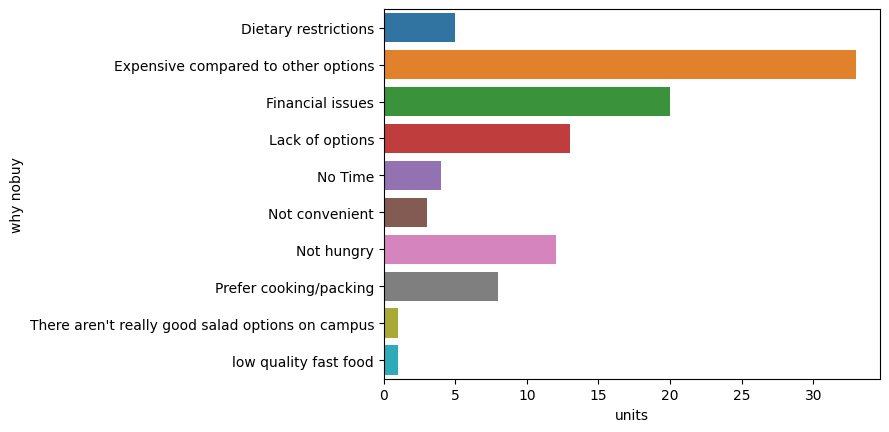

In [18]:
sns.barplot(data=pivot, y=pivot.index, x='units')

In [19]:
new_table = pd.crosstab(index=data.units, columns=data['why nobuy'], margins=True)
no_margins = pd.crosstab(index=data.units, columns=data['why nobuy'], margins=False)

<AxesSubplot: xlabel='why nobuy', ylabel='units'>

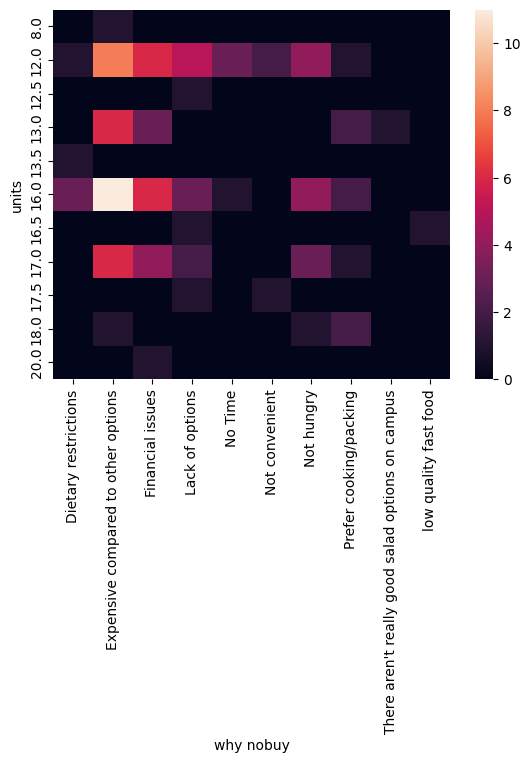

In [20]:
sns.heatmap(data=no_margins)

In [21]:
chi2, p, df, expected = chi2_contingency(no_margins)

In [22]:
chi2, p, df, expected

(139.79489607614605,
 0.0006071059328953659,
 90,
 array([[0.05, 0.33, 0.2 , 0.13, 0.04, 0.03, 0.12, 0.08, 0.01, 0.01],
        [1.5 , 9.9 , 6.  , 3.9 , 1.2 , 0.9 , 3.6 , 2.4 , 0.3 , 0.3 ],
        [0.05, 0.33, 0.2 , 0.13, 0.04, 0.03, 0.12, 0.08, 0.01, 0.01],
        [0.6 , 3.96, 2.4 , 1.56, 0.48, 0.36, 1.44, 0.96, 0.12, 0.12],
        [0.05, 0.33, 0.2 , 0.13, 0.04, 0.03, 0.12, 0.08, 0.01, 0.01],
        [1.5 , 9.9 , 6.  , 3.9 , 1.2 , 0.9 , 3.6 , 2.4 , 0.3 , 0.3 ],
        [0.1 , 0.66, 0.4 , 0.26, 0.08, 0.06, 0.24, 0.16, 0.02, 0.02],
        [0.8 , 5.28, 3.2 , 2.08, 0.64, 0.48, 1.92, 1.28, 0.16, 0.16],
        [0.1 , 0.66, 0.4 , 0.26, 0.08, 0.06, 0.24, 0.16, 0.02, 0.02],
        [0.2 , 1.32, 0.8 , 0.52, 0.16, 0.12, 0.48, 0.32, 0.04, 0.04],
        [0.05, 0.33, 0.2 , 0.13, 0.04, 0.03, 0.12, 0.08, 0.01, 0.01]]))